# Dask DataFrames

<img src="images/dask-dataframe.svg"
     align="right"
     width="20%"
     alt="Dask dataframes are blocked Pandas dataframes">
     
Dask Dataframes coordinate many Pandas dataframes, partitioned along an index.  They support a large subset of the Pandas API.

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [3]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")
client


/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44853 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45211
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:44853/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39449'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34697'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:35339', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35339
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33008
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:41333', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44853/status,
Dashboard: http://127.0.0.1:44853/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45211,Workers: 2
Dashboard: http://127.0.0.1:44853/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:35339,Total threads: 2
Dashboard: http://127.0.0.1:36805/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:39449,


## Create Random Dataframe

We create a random timeseries of data with the following attributes:

1.  It stores a record for every second in the month of January of the year 2000
2.  It splits that month by day, keeping each day as a partitioned dataframe
3.  Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 240 MB. Increase the number of days or reduce the time interval between data points to practice with a larger dataset by setting some of the [`dask.datasets.timeseries()` arguments](https://docs.dask.org/en/stable/api.html#dask.datasets.timeseries).

In [4]:
import dask

df = dask.datasets.timeseries()


Unlike Pandas, Dask DataFrames are _lazy_, meaning that data is only loaded when it is needed for a computation. No data is printed here, instead it is replaced by ellipses (`...`).

In [5]:
df


,name,id,x,y
npartitions=30,,,,
2000-01-01,string,int64,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


Nonetheless, the column names and dtypes are known.

In [6]:
df.dtypes


name    string[pyarrow]
id                int64
x               float64
y               float64
dtype: object

Some operations will automatically display the data.

In [7]:
# This sets some formatting parameters for displayed data.
import pandas as pd

pd.options.display.precision = 2
pd.options.display.max_rows = 10


In [8]:
df.head(3)


,name,id,x,y
timestamp,,,,
2000-01-01 00:00:00,Hannah,1014,-0.79,0.72
2000-01-01 00:00:01,Laura,974,0.36,0.12
2000-01-01 00:00:02,Jerry,1029,0.38,0.71


## Use Standard Pandas Operations

Most common Pandas operations can be used in the same way on Dask dataframes. This example shows how to slice the data based on a mask condition and then determine the standard deviation of the data in the `x` column.

In [9]:
df2 = df[df.y > 0]
df3 = df2.groupby("name").x.std()
df3


Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 10 graph layers

Notice that the data in `df3` are still represented by ellipses. All of the operations in the previous cell are lazy operations. You can call `.compute()` when you want your result as a Pandas dataframe or series.

If you started `Client()` above then you can watch the status page during computation to see the progress.

In [10]:
computed_df = df3.compute()
type(computed_df)


pandas.core.series.Series

In [11]:
computed_df


name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

Notice that the computed data are now shown in the output.

Another example calculation is to aggregate multiple columns, as shown below. Once again, the dashboard will show the progress of the computation.

In [12]:
df4 = df.groupby("name").aggregate({"x": "sum", "y": "max"})
df4.compute()


,x,y
name,,
Hannah,117.51,1.0
Laura,201.96,1.0
Jerry,-181.04,1.0
Tim,-149.09,1.0
Charlie,174.22,1.0
...,...,...
Xavier,-17.64,1.0
Michael,39.09,1.0
Alice,2.45,1.0


Dask dataframes can also be joined like Pandas dataframes. In this example we join the aggregated data in `df4` with the original data in `df`. Since the index in `df` is the timeseries and `df4` is indexed by names, we use `left_on="name"` and `right_index=True` to define the merge columns. We also set suffixes for any columns that are common between the two dataframes so that we can distinguish them.

Finally, since `df4` is small, we also make sure that it is a single partition dataframe.

In [13]:
df4 = df4.repartition(npartitions=1)
joined = df.merge(
    df4, left_on="name", right_index=True, suffixes=("_original", "_aggregated")
)
joined.head()


,name,id,x_original,y_original,x_aggregated,y_aggregated
timestamp,,,,,,
2000-01-01 00:00:00,Hannah,1014,-0.79,0.72,117.51,1.0
2000-01-01 00:00:26,Hannah,1009,-0.08,0.92,117.51,1.0
2000-01-01 00:00:29,Hannah,1008,-0.14,-0.56,117.51,1.0
2000-01-01 00:00:54,Hannah,999,-0.08,0.91,117.51,1.0
2000-01-01 00:01:09,Hannah,1009,0.33,0.22,117.51,1.0


## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [14]:
df = df.persist()


## Time Series Operations

Because `df` has a datetime index, time-series operations work efficiently.

The first example below resamples the data at 1 hour intervals to reduce the total size of the dataframe. Then the mean of the `x` and `y` columns are taken.

In [15]:
df[["x", "y"]].resample("1h").mean().head()


,x,y
timestamp,,
2000-01-01 00:00:00,1.38e-02,5.25e-03
2000-01-01 01:00:00,-9.35e-03,-3.70e-04
2000-01-01 02:00:00,-1.03e-05,-1.42e-02
2000-01-01 03:00:00,3.69e-03,-1.13e-02
2000-01-01 04:00:00,1.37e-03,2.21e-02


The next example resamples the data at 24 hour intervals and plots the mean values. Notice that `plot()` is called after `compute()` because `plot()` will not work until the data are computed.

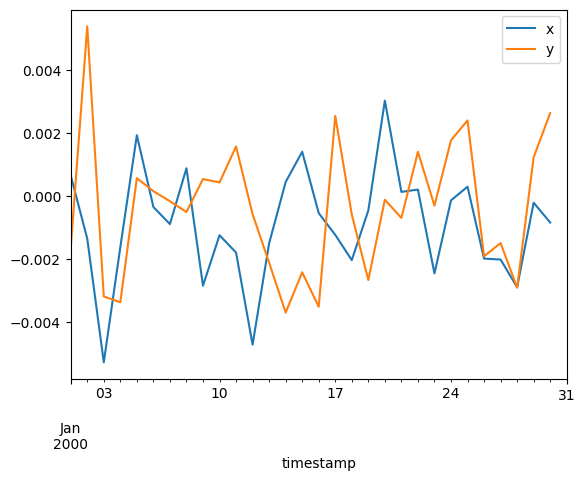

In [16]:
%matplotlib inline
df[['x', 'y']].resample('24h').mean().compute().plot();

This final example computes the rolling 24 hour mean of the data.

In [17]:
df[["x", "y"]].rolling(window="24h").mean().head()


,x,y
timestamp,,
2000-01-01 00:00:00,-7.89e-01,0.72
2000-01-01 00:00:01,-2.15e-01,0.42
2000-01-01 00:00:02,-1.61e-02,0.52
2000-01-01 00:00:03,2.28e-01,0.33
2000-01-01 00:00:04,5.83e-04,0.11


Random access is cheap along the index, but must since the Dask dataframe is lazy, it must be computed to materialize the data.

In [18]:
df.loc["2000-01-05"]


,name,id,x,y
npartitions=1,,,,
2000-01-05 00:00:00.000000000,string,int64,float64,float64
2000-01-05 23:59:59.999999999,...,...,...,...


In [19]:
%time df.loc['2000-01-05'].compute()

CPU times: user 17.4 ms, sys: 11 ms, total: 28.4 ms
Wall time: 47.4 ms


,name,id,x,y
timestamp,,,,
2000-01-05 00:00:00,Dan,949,0.44,0.18
2000-01-05 00:00:01,Victor,957,0.69,0.13
2000-01-05 00:00:02,Edith,1010,0.75,0.52
2000-01-05 00:00:03,Sarah,963,-0.46,0.89
2000-01-05 00:00:04,Victor,1014,0.68,0.06
...,...,...,...,...
2000-01-05 23:59:55,Laura,1039,-0.03,-0.29
2000-01-05 23:59:56,Michael,987,-0.95,-0.02
2000-01-05 23:59:57,Yvonne,1028,-0.27,0.92


## Set Index

Data is sorted by the index column. This allows for faster access, joins, groupby-apply operations, and more. However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently. In the next few examples, we will group the data by the `name` column, so we will set that column as the index to improve efficiency.

In [20]:
df5 = df.set_index("name")
df5


,id,x,y
npartitions=26,,,
Alice,int64,float64,float64
Bob,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Because resetting the index for this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [21]:
df5 = df5.persist()
df5


,id,x,y
npartitions=26,,,
Alice,int64,float64,float64
Bob,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Dask now knows where all data lives, indexed by name. As a result operations like random access are cheap and efficient.

In [22]:
%time df5.loc['Alice'].compute()

CPU times: user 17.4 ms, sys: 7.39 ms, total: 24.8 ms
Wall time: 52.6 ms


,id,x,y
name,,,
Alice,960,-0.34,0.53
Alice,1054,0.26,-0.50
Alice,1005,0.49,-0.23
Alice,993,0.77,-0.70
Alice,966,-0.36,-0.02
...,...,...,...
Alice,989,0.61,0.64
Alice,1007,0.53,0.80
Alice,1005,0.01,0.13


## Groupby Apply with Scikit-Learn

Now that our data is sorted by name we can inexpensively do operations like random access on name, or groupby-apply with custom functions.

Here we train a different scikit-learn linear regression model on each name.

In [23]:
from sklearn.linear_model import LinearRegression


def train(partition):
    if not len(partition):
        return
    est = LinearRegression()
    est.fit(partition[["x"]].values, partition.y.values)
    return est


The `partition` argument to `train()` will be one of the group instances from the `DataFrameGroupBy`. If there is no data in the partition, we don't need to proceed. If there is data, we want to fit the linear regression model and return that as the value for this group.

Now working with `df5`, whose index is the names from `df`, we can group by the `names` column. This also happens to be the index, but that's fine. Then we use `.apply()` to run `train()` on each group in the `DataFrameGroupBy` generated by `.groupby()`.

The `meta` argument tells Dask how to create the `DataFrame` or `Series` that will hold the result of `.apply()`. In this case, `train()` returns a single value, so `.apply()` will create a `Series`. This means we need to tell Dask what the type of that single column should be and optionally give it a name.

The easiest way to specify a single column is with a tuple. The name of the column is the first element of the tuple. Since this is a series of linear regressions, we will name the column `"LinearRegression"`. The second element of the tuple is the type of the return value of `train`. In this case, Pandas will store the result as a general `object`, which should be the type we pass.

In [24]:
df6 = df5.groupby("name").apply(
    train, meta=("LinearRegression", object)
).compute()
df6

name
Alice      LinearRegression()
Bob        LinearRegression()
Charlie    LinearRegression()
Dan        LinearRegression()
Edith      LinearRegression()
                  ...        
Victor     LinearRegression()
Wendy      LinearRegression()
Xavier     LinearRegression()
Yvonne     LinearRegression()
Zelda      LinearRegression()
Name: LinearRegression, Length: 26, dtype: string

## Further Reading

For a more in-depth introduction to Dask dataframes, see the [dask tutorial](https://github.com/dask/dask-tutorial), notebooks 04 and 07.